# Action detection using OpenCV

Here I design a application using the OpenCV library, that detects if a head turns left or right by training from a set of video frames. The model draws inspiration from [nicknochnack](https://github.com/nicknochnack/ActionDetectionforSignLanguage) with the following key changes:

* Model is trained on video files rather than dynamic capture from the webcam. This enables us to train the model on videos from from multiple sources.
* I use streamlit to built the application' web interface and [deploy](https://github.com/Seymour22/OpenCV_Application) it on the cloud.
* The application can be used on a live webcam feed or uploading a video file.

# 1. Import and Install Dependencies

In [3]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [4]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [69]:
def draw_landmarks(image, results):
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [233]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [338]:
cap = cv2.VideoCapture('/Users/seymour/Desktop/OpenCV/Data_turns/Left/0/0.mp4')

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()

        # Check if end of video
        if not ret:
            break
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        frame1=frame

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()


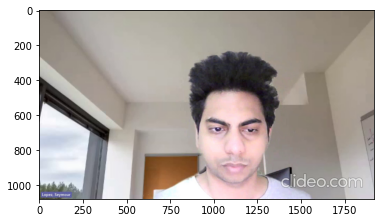

In [339]:
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))

In [340]:
len(results.pose_landmarks.landmark)

33

# 3. Extract Keypoint Values

In [286]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [342]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [344]:
result_test = extract_keypoints(results)

In [345]:
extract_keypoints(results).shape

(1662,)

In [346]:
np.save('0', result_test)

In [347]:
result_test.shape

(1662,)

In [348]:
np.load('0.npy')

array([ 0.58421636,  0.71977466, -1.12205243, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection

In [349]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Data_turns') 

# Actions that we try to detect
actions = np.array(['Left', 'Right'])

# Thirty videos worth of data
no_sequences = 3

# Videos are going to be 30 frames in length
sequence_length = 3

# Folder start
start_folder = 0

In [350]:
# for action in actions: 
#     dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
#     for sequence in range(1,no_sequences+1):
#         try: 
#             os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
#         except:
#             pass

# 5. Collect Keypoint Values for Training and Testing

In [351]:

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                print(action)
   
                image_path = os.path.join(DATA_PATH, action,str(sequence), f'{sequence}.mp4')
                print(('./'+f'{image_path}'))
                cap = cv2.VideoCapture('./'+f'{image_path}')

                while cap.isOpened():
                    # Read a single frame from the video
                    ret, frame = cap.read()

                    # If the frame could not be read, break out of the loop
                    if not ret:
                        break

                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)
                    print(results)

                    # Draw landmarks
                    draw_styled_landmarks(image, results)

                    # Show the frame
                    cv2.imshow('OpenCV Feed', image)
                    
                    # NEW Export keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)

                    # Wait for a key press
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break

    cap.release()
    cv2.destroyAllWindows()


Left
./Data_turns/Left/0/0.mp4
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Left
./Data_turns/Left/1/1.mp4
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
Right
./Data_turns/Right/0/0.mp4
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [352]:
keypoints

array([ 0.53968143,  0.71762961, -0.94377697, ...,  0.        ,
        0.        ,  0.        ])

# 6. Preprocess Data and Create Labels and Features

In [353]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [354]:
label_map = {label:num for num, label in enumerate(actions)}

In [355]:
label_map

{'Left': 0, 'Right': 1}

In [356]:
sequences, labels = [], []
for action in actions:
    for sequence in os.listdir(os.path.join(DATA_PATH, action)):
        if not sequence.startswith('.') and sequence.isdigit():
            sequence = int(sequence)
            print(np.array(sequences).shape)
            window = []
            for frame_num in range(sequence_length):
                res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])

(0,)
(1, 3, 1662)
(2, 3, 1662)
(3, 3, 1662)
(4, 3, 1662)
(5, 3, 1662)


In [357]:
np.array(sequences).shape

(6, 3, 1662)

In [358]:
np.array(labels).shape

(6,)

In [359]:
X = np.array(sequences)

In [360]:
X.shape

(6, 3, 1662)

In [361]:
y = to_categorical(labels).astype(int)

In [362]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [363]:
y_test.shape

(1, 2)

# 7. Build and Train LSTM Neural Network

In [364]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [365]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [366]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(3,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [367]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [368]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
1/1 [==============================] - 3s 3s/step - loss: 0.6938 - categorical_accuracy: 0.4000
Epoch 2/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.6933 - categorical_accuracy: 0.6000
Epoch 3/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.6909 - categorical_accuracy: 0.6000
Epoch 4/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.6878 - categorical_accuracy: 0.6000
Epoch 5/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.6833 - categorical_accuracy: 0.6000
Epoch 6/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.6781 - categorical_accuracy: 0.6000
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.6763 - categorical_accuracy: 0.6000
Epoch 8/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.6767 - categorical_accuracy: 0.6000
Epoch 9/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.6735 - categorical_accuracy: 0.6000
Epo

1/1 [==============================] - 0s 11ms/step - loss: 0.1065 - categorical_accuracy: 1.0000
Epoch 75/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.0817 - categorical_accuracy: 1.0000
Epoch 76/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0613 - categorical_accuracy: 1.0000
Epoch 77/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0493 - categorical_accuracy: 1.0000
Epoch 78/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0415 - categorical_accuracy: 1.0000
Epoch 79/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.0338 - categorical_accuracy: 1.0000
Epoch 80/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.0239 - categorical_accuracy: 1.0000
Epoch 81/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0151 - categorical_accuracy: 1.0000
Epoch 82/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.0098 - categorical_accuracy: 1.0000
Epoch 83/

1/1 [==============================] - 0s 11ms/step - loss: 5.5790e-06 - categorical_accuracy: 1.0000
Epoch 146/2000
1/1 [==============================] - 0s 10ms/step - loss: 5.5075e-06 - categorical_accuracy: 1.0000
Epoch 147/2000
1/1 [==============================] - 0s 9ms/step - loss: 5.3882e-06 - categorical_accuracy: 1.0000
Epoch 148/2000
1/1 [==============================] - 0s 10ms/step - loss: 5.3167e-06 - categorical_accuracy: 1.0000
Epoch 149/2000
1/1 [==============================] - 0s 9ms/step - loss: 5.1975e-06 - categorical_accuracy: 1.0000
Epoch 150/2000
1/1 [==============================] - 0s 8ms/step - loss: 5.1260e-06 - categorical_accuracy: 1.0000
Epoch 151/2000
1/1 [==============================] - 0s 10ms/step - loss: 5.0783e-06 - categorical_accuracy: 1.0000
Epoch 152/2000
1/1 [==============================] - 0s 10ms/step - loss: 5.0068e-06 - categorical_accuracy: 1.0000
Epoch 153/2000
1/1 [==============================] - 0s 10ms/step - loss: 4.9591e

1/1 [==============================] - 0s 9ms/step - loss: 3.2425e-06 - categorical_accuracy: 1.0000
Epoch 216/2000
1/1 [==============================] - 0s 9ms/step - loss: 3.2425e-06 - categorical_accuracy: 1.0000
Epoch 217/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.2425e-06 - categorical_accuracy: 1.0000
Epoch 218/2000
1/1 [==============================] - 0s 9ms/step - loss: 3.1948e-06 - categorical_accuracy: 1.0000
Epoch 219/2000
1/1 [==============================] - 0s 9ms/step - loss: 3.1948e-06 - categorical_accuracy: 1.0000
Epoch 220/2000
1/1 [==============================] - 0s 11ms/step - loss: 3.1710e-06 - categorical_accuracy: 1.0000
Epoch 221/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.1710e-06 - categorical_accuracy: 1.0000
Epoch 222/2000
1/1 [==============================] - 0s 8ms/step - loss: 3.1710e-06 - categorical_accuracy: 1.0000
Epoch 223/2000
1/1 [==============================] - 0s 11ms/step - loss: 3.0994e-0

1/1 [==============================] - 0s 11ms/step - loss: 2.3603e-06 - categorical_accuracy: 1.0000
Epoch 286/2000
1/1 [==============================] - 0s 8ms/step - loss: 2.3603e-06 - categorical_accuracy: 1.0000
Epoch 287/2000
1/1 [==============================] - 0s 10ms/step - loss: 2.3603e-06 - categorical_accuracy: 1.0000
Epoch 288/2000
1/1 [==============================] - 0s 11ms/step - loss: 2.3603e-06 - categorical_accuracy: 1.0000
Epoch 289/2000
1/1 [==============================] - 0s 8ms/step - loss: 2.3127e-06 - categorical_accuracy: 1.0000
Epoch 290/2000
1/1 [==============================] - 0s 11ms/step - loss: 2.2888e-06 - categorical_accuracy: 1.0000
Epoch 291/2000
1/1 [==============================] - 0s 10ms/step - loss: 2.2650e-06 - categorical_accuracy: 1.0000
Epoch 292/2000
1/1 [==============================] - 0s 9ms/step - loss: 2.2650e-06 - categorical_accuracy: 1.0000
Epoch 293/2000
1/1 [==============================] - 0s 9ms/step - loss: 2.2650e-

1/1 [==============================] - 0s 13ms/step - loss: 1.7405e-06 - categorical_accuracy: 1.0000
Epoch 356/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.7405e-06 - categorical_accuracy: 1.0000
Epoch 357/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.7405e-06 - categorical_accuracy: 1.0000
Epoch 358/2000
1/1 [==============================] - 0s 8ms/step - loss: 1.7405e-06 - categorical_accuracy: 1.0000
Epoch 359/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.7405e-06 - categorical_accuracy: 1.0000
Epoch 360/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.7405e-06 - categorical_accuracy: 1.0000
Epoch 361/2000
1/1 [==============================] - 0s 8ms/step - loss: 1.7405e-06 - categorical_accuracy: 1.0000
Epoch 362/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.7166e-06 - categorical_accuracy: 1.0000
Epoch 363/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.7166

1/1 [==============================] - 0s 10ms/step - loss: 1.3828e-06 - categorical_accuracy: 1.0000
Epoch 426/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.3828e-06 - categorical_accuracy: 1.0000
Epoch 427/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.3828e-06 - categorical_accuracy: 1.0000
Epoch 428/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.3828e-06 - categorical_accuracy: 1.0000
Epoch 429/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.3828e-06 - categorical_accuracy: 1.0000
Epoch 430/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.3590e-06 - categorical_accuracy: 1.0000
Epoch 431/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.3590e-06 - categorical_accuracy: 1.0000
Epoch 432/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.3590e-06 - categorical_accuracy: 1.0000
Epoch 433/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.3590e

1/1 [==============================] - 0s 10ms/step - loss: 1.0967e-06 - categorical_accuracy: 1.0000
Epoch 496/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.0967e-06 - categorical_accuracy: 1.0000
Epoch 497/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.0729e-06 - categorical_accuracy: 1.0000
Epoch 498/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.0729e-06 - categorical_accuracy: 1.0000
Epoch 499/2000
1/1 [==============================] - 0s 12ms/step - loss: 1.0729e-06 - categorical_accuracy: 1.0000
Epoch 500/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.0729e-06 - categorical_accuracy: 1.0000
Epoch 501/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.0729e-06 - categorical_accuracy: 1.0000
Epoch 502/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.0729e-06 - categorical_accuracy: 1.0000
Epoch 503/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.072

1/1 [==============================] - 0s 8ms/step - loss: 9.0599e-07 - categorical_accuracy: 1.0000
Epoch 566/2000
1/1 [==============================] - 0s 8ms/step - loss: 9.0599e-07 - categorical_accuracy: 1.0000
Epoch 567/2000
1/1 [==============================] - 0s 8ms/step - loss: 9.0599e-07 - categorical_accuracy: 1.0000
Epoch 568/2000
1/1 [==============================] - 0s 9ms/step - loss: 9.0599e-07 - categorical_accuracy: 1.0000
Epoch 569/2000
1/1 [==============================] - 0s 8ms/step - loss: 9.0599e-07 - categorical_accuracy: 1.0000
Epoch 570/2000
1/1 [==============================] - 0s 9ms/step - loss: 9.0599e-07 - categorical_accuracy: 1.0000
Epoch 571/2000
1/1 [==============================] - 0s 11ms/step - loss: 9.0599e-07 - categorical_accuracy: 1.0000
Epoch 572/2000
1/1 [==============================] - 0s 10ms/step - loss: 9.0599e-07 - categorical_accuracy: 1.0000
Epoch 573/2000
1/1 [==============================] - 0s 11ms/step - loss: 9.0599e-07

1/1 [==============================] - 0s 11ms/step - loss: 7.3910e-07 - categorical_accuracy: 1.0000
Epoch 636/2000
1/1 [==============================] - 0s 10ms/step - loss: 7.3910e-07 - categorical_accuracy: 1.0000
Epoch 637/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.3910e-07 - categorical_accuracy: 1.0000
Epoch 638/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.3910e-07 - categorical_accuracy: 1.0000
Epoch 639/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.3910e-07 - categorical_accuracy: 1.0000
Epoch 640/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.3910e-07 - categorical_accuracy: 1.0000
Epoch 641/2000
1/1 [==============================] - 0s 10ms/step - loss: 7.3910e-07 - categorical_accuracy: 1.0000
Epoch 642/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.3910e-07 - categorical_accuracy: 1.0000
Epoch 643/2000
1/1 [==============================] - 0s 8ms/step - loss: 7.3910e-07

1/1 [==============================] - 0s 10ms/step - loss: 6.4373e-07 - categorical_accuracy: 1.0000
Epoch 706/2000
1/1 [==============================] - 0s 10ms/step - loss: 6.4373e-07 - categorical_accuracy: 1.0000
Epoch 707/2000
1/1 [==============================] - 0s 10ms/step - loss: 6.4373e-07 - categorical_accuracy: 1.0000
Epoch 708/2000
1/1 [==============================] - 0s 8ms/step - loss: 6.4373e-07 - categorical_accuracy: 1.0000
Epoch 709/2000
1/1 [==============================] - 0s 10ms/step - loss: 6.1989e-07 - categorical_accuracy: 1.0000
Epoch 710/2000
1/1 [==============================] - 0s 9ms/step - loss: 6.1989e-07 - categorical_accuracy: 1.0000
Epoch 711/2000
1/1 [==============================] - 0s 9ms/step - loss: 6.1989e-07 - categorical_accuracy: 1.0000
Epoch 712/2000
1/1 [==============================] - 0s 11ms/step - loss: 5.9605e-07 - categorical_accuracy: 1.0000
Epoch 713/2000
1/1 [==============================] - 0s 12ms/step - loss: 5.9605e

1/1 [==============================] - 0s 9ms/step - loss: 5.4836e-07 - categorical_accuracy: 1.0000
Epoch 776/2000
1/1 [==============================] - 0s 11ms/step - loss: 5.4836e-07 - categorical_accuracy: 1.0000
Epoch 777/2000
1/1 [==============================] - 0s 9ms/step - loss: 5.4836e-07 - categorical_accuracy: 1.0000
Epoch 778/2000
1/1 [==============================] - 0s 9ms/step - loss: 5.4836e-07 - categorical_accuracy: 1.0000
Epoch 779/2000
1/1 [==============================] - 0s 10ms/step - loss: 5.4836e-07 - categorical_accuracy: 1.0000
Epoch 780/2000
1/1 [==============================] - 0s 11ms/step - loss: 5.4836e-07 - categorical_accuracy: 1.0000
Epoch 781/2000
1/1 [==============================] - 0s 11ms/step - loss: 5.4836e-07 - categorical_accuracy: 1.0000
Epoch 782/2000
1/1 [==============================] - 0s 8ms/step - loss: 5.4836e-07 - categorical_accuracy: 1.0000
Epoch 783/2000
1/1 [==============================] - 0s 11ms/step - loss: 5.2452e-

1/1 [==============================] - 0s 9ms/step - loss: 4.7684e-07 - categorical_accuracy: 1.0000
Epoch 846/2000
1/1 [==============================] - 0s 10ms/step - loss: 4.7684e-07 - categorical_accuracy: 1.0000
Epoch 847/2000
1/1 [==============================] - 0s 11ms/step - loss: 4.7684e-07 - categorical_accuracy: 1.0000
Epoch 848/2000
1/1 [==============================] - 0s 10ms/step - loss: 4.7684e-07 - categorical_accuracy: 1.0000
Epoch 849/2000
1/1 [==============================] - 0s 8ms/step - loss: 4.7684e-07 - categorical_accuracy: 1.0000
Epoch 850/2000
1/1 [==============================] - 0s 12ms/step - loss: 4.5300e-07 - categorical_accuracy: 1.0000
Epoch 851/2000
1/1 [==============================] - 0s 11ms/step - loss: 4.5300e-07 - categorical_accuracy: 1.0000
Epoch 852/2000
1/1 [==============================] - 0s 10ms/step - loss: 4.5300e-07 - categorical_accuracy: 1.0000
Epoch 853/2000
1/1 [==============================] - 0s 8ms/step - loss: 4.5300e

1/1 [==============================] - 0s 11ms/step - loss: 4.2915e-07 - categorical_accuracy: 1.0000
Epoch 916/2000
1/1 [==============================] - 0s 9ms/step - loss: 4.2915e-07 - categorical_accuracy: 1.0000
Epoch 917/2000
1/1 [==============================] - 0s 11ms/step - loss: 4.2915e-07 - categorical_accuracy: 1.0000
Epoch 918/2000
1/1 [==============================] - 0s 11ms/step - loss: 4.0531e-07 - categorical_accuracy: 1.0000
Epoch 919/2000
1/1 [==============================] - 0s 12ms/step - loss: 3.8147e-07 - categorical_accuracy: 1.0000
Epoch 920/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.8147e-07 - categorical_accuracy: 1.0000
Epoch 921/2000
1/1 [==============================] - 0s 9ms/step - loss: 3.8147e-07 - categorical_accuracy: 1.0000
Epoch 922/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.8147e-07 - categorical_accuracy: 1.0000
Epoch 923/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.8147

1/1 [==============================] - 0s 11ms/step - loss: 3.3379e-07 - categorical_accuracy: 1.0000
Epoch 986/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.3379e-07 - categorical_accuracy: 1.0000
Epoch 987/2000
1/1 [==============================] - 0s 9ms/step - loss: 3.3379e-07 - categorical_accuracy: 1.0000
Epoch 988/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.3379e-07 - categorical_accuracy: 1.0000
Epoch 989/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.3379e-07 - categorical_accuracy: 1.0000
Epoch 990/2000
1/1 [==============================] - 0s 9ms/step - loss: 3.3379e-07 - categorical_accuracy: 1.0000
Epoch 991/2000
1/1 [==============================] - 0s 12ms/step - loss: 3.3379e-07 - categorical_accuracy: 1.0000
Epoch 992/2000
1/1 [==============================] - 0s 11ms/step - loss: 3.3379e-07 - categorical_accuracy: 1.0000
Epoch 993/2000
1/1 [==============================] - 0s 11ms/step - loss: 3.3379

1/1 [==============================] - 0s 12ms/step - loss: 3.0994e-07 - categorical_accuracy: 1.0000
Epoch 1055/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.0994e-07 - categorical_accuracy: 1.0000
Epoch 1056/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.0994e-07 - categorical_accuracy: 1.0000
Epoch 1057/2000
1/1 [==============================] - 0s 9ms/step - loss: 3.0994e-07 - categorical_accuracy: 1.0000
Epoch 1058/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.0994e-07 - categorical_accuracy: 1.0000
Epoch 1059/2000
1/1 [==============================] - 0s 11ms/step - loss: 3.0994e-07 - categorical_accuracy: 1.0000
Epoch 1060/2000
1/1 [==============================] - 0s 11ms/step - loss: 3.0994e-07 - categorical_accuracy: 1.0000
Epoch 1061/2000
1/1 [==============================] - 0s 10ms/step - loss: 3.0994e-07 - categorical_accuracy: 1.0000
Epoch 1062/2000
1/1 [==============================] - 0s 11ms/step - los

1/1 [==============================] - 0s 11ms/step - loss: 2.6226e-07 - categorical_accuracy: 1.0000
Epoch 1124/2000
1/1 [==============================] - 0s 10ms/step - loss: 2.6226e-07 - categorical_accuracy: 1.0000
Epoch 1125/2000
1/1 [==============================] - 0s 10ms/step - loss: 2.6226e-07 - categorical_accuracy: 1.0000
Epoch 1126/2000
1/1 [==============================] - 0s 9ms/step - loss: 2.6226e-07 - categorical_accuracy: 1.0000
Epoch 1127/2000
1/1 [==============================] - 0s 10ms/step - loss: 2.6226e-07 - categorical_accuracy: 1.0000
Epoch 1128/2000
1/1 [==============================] - 0s 10ms/step - loss: 2.6226e-07 - categorical_accuracy: 1.0000
Epoch 1129/2000
1/1 [==============================] - 0s 11ms/step - loss: 2.6226e-07 - categorical_accuracy: 1.0000
Epoch 1130/2000
1/1 [==============================] - 0s 11ms/step - loss: 2.6226e-07 - categorical_accuracy: 1.0000
Epoch 1131/2000
1/1 [==============================] - 0s 9ms/step - loss

1/1 [==============================] - 0s 11ms/step - loss: 2.3842e-07 - categorical_accuracy: 1.0000
Epoch 1193/2000
1/1 [==============================] - 0s 12ms/step - loss: 2.3842e-07 - categorical_accuracy: 1.0000
Epoch 1194/2000
1/1 [==============================] - 0s 11ms/step - loss: 2.3842e-07 - categorical_accuracy: 1.0000
Epoch 1195/2000
1/1 [==============================] - 0s 9ms/step - loss: 2.3842e-07 - categorical_accuracy: 1.0000
Epoch 1196/2000
1/1 [==============================] - 0s 11ms/step - loss: 2.3842e-07 - categorical_accuracy: 1.0000
Epoch 1197/2000
1/1 [==============================] - 0s 10ms/step - loss: 2.3842e-07 - categorical_accuracy: 1.0000
Epoch 1198/2000
1/1 [==============================] - 0s 10ms/step - loss: 2.3842e-07 - categorical_accuracy: 1.0000
Epoch 1199/2000
1/1 [==============================] - 0s 9ms/step - loss: 2.3842e-07 - categorical_accuracy: 1.0000
Epoch 1200/2000
1/1 [==============================] - 0s 11ms/step - loss

1/1 [==============================] - 0s 12ms/step - loss: 2.1458e-07 - categorical_accuracy: 1.0000
Epoch 1262/2000
1/1 [==============================] - 0s 11ms/step - loss: 2.1458e-07 - categorical_accuracy: 1.0000
Epoch 1263/2000
1/1 [==============================] - 0s 11ms/step - loss: 2.1458e-07 - categorical_accuracy: 1.0000
Epoch 1264/2000
1/1 [==============================] - 0s 10ms/step - loss: 2.1458e-07 - categorical_accuracy: 1.0000
Epoch 1265/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1266/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1267/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1268/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1269/2000
1/1 [==============================] - 0s 11ms/step - loss

1/1 [==============================] - 0s 10ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1331/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1332/2000
1/1 [==============================] - 0s 8ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1333/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1334/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1335/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1336/2000
1/1 [==============================] - 0s 8ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1337/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1338/2000
1/1 [==============================] - 0s 10ms/step - loss: 

1/1 [==============================] - 0s 9ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1400/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1401/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1402/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1403/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1404/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1405/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1406/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.9073e-07 - categorical_accuracy: 1.0000
Epoch 1407/2000
1/1 [==============================] - 0s 9ms/step - loss:

1/1 [==============================] - 0s 11ms/step - loss: 1.6689e-07 - categorical_accuracy: 1.0000
Epoch 1469/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.6689e-07 - categorical_accuracy: 1.0000
Epoch 1470/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.6689e-07 - categorical_accuracy: 1.0000
Epoch 1471/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.6689e-07 - categorical_accuracy: 1.0000
Epoch 1472/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.6689e-07 - categorical_accuracy: 1.0000
Epoch 1473/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.6689e-07 - categorical_accuracy: 1.0000
Epoch 1474/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.6689e-07 - categorical_accuracy: 1.0000
Epoch 1475/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.6689e-07 - categorical_accuracy: 1.0000
Epoch 1476/2000
1/1 [==============================] - 0s 10ms/step - loss: 

1/1 [==============================] - 0s 12ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1538/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1539/2000
1/1 [==============================] - 0s 12ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1540/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1541/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1542/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1543/2000
1/1 [==============================] - 0s 12ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1544/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1545/2000
1/1 [==============================] - 0s 9ms/step - loss

1/1 [==============================] - 0s 11ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1607/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1608/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1609/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1610/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1611/2000
1/1 [==============================] - 0s 8ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1612/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1613/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1614/2000
1/1 [==============================] - 0s 9ms/step - loss: 1

1/1 [==============================] - 0s 10ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1676/2000
1/1 [==============================] - 0s 8ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1677/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1678/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1679/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1680/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1681/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1682/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1683/2000
1/1 [==============================] - 0s 10ms/step - loss

1/1 [==============================] - 0s 11ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1745/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1746/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1747/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1748/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1749/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1750/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1751/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000
Epoch 1752/2000
1/1 [==============================] - 0s 10ms/step - loss:

1/1 [==============================] - 0s 10ms/step - loss: 9.5367e-08 - categorical_accuracy: 1.0000
Epoch 1814/2000
1/1 [==============================] - 0s 11ms/step - loss: 9.5367e-08 - categorical_accuracy: 1.0000
Epoch 1815/2000
1/1 [==============================] - 0s 9ms/step - loss: 9.5367e-08 - categorical_accuracy: 1.0000
Epoch 1816/2000
1/1 [==============================] - 0s 12ms/step - loss: 9.5367e-08 - categorical_accuracy: 1.0000
Epoch 1817/2000
1/1 [==============================] - 0s 11ms/step - loss: 9.5367e-08 - categorical_accuracy: 1.0000
Epoch 1818/2000
1/1 [==============================] - 0s 11ms/step - loss: 9.5367e-08 - categorical_accuracy: 1.0000
Epoch 1819/2000
1/1 [==============================] - 0s 9ms/step - loss: 9.5367e-08 - categorical_accuracy: 1.0000
Epoch 1820/2000
1/1 [==============================] - 0s 10ms/step - loss: 9.5367e-08 - categorical_accuracy: 1.0000
Epoch 1821/2000
1/1 [==============================] - 0s 9ms/step - loss:

1/1 [==============================] - 0s 10ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1883/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1884/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1885/2000
1/1 [==============================] - 0s 10ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1886/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1887/2000
1/1 [==============================] - 0s 8ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1888/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1889/2000
1/1 [==============================] - 0s 11ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1890/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.

1/1 [==============================] - 0s 10ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1952/2000
1/1 [==============================] - 0s 10ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1953/2000
1/1 [==============================] - 0s 10ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1954/2000
1/1 [==============================] - 0s 10ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1955/2000
1/1 [==============================] - 0s 10ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1956/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1957/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1958/2000
1/1 [==============================] - 0s 9ms/step - loss: 7.1526e-08 - categorical_accuracy: 1.0000
Epoch 1959/2000
1/1 [==============================] - 0s 10ms/step - loss:

In [369]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 3, 64)             442112    
                                                                 
 lstm_21 (LSTM)              (None, 3, 128)            98816     
                                                                 
 lstm_22 (LSTM)              (None, 64)                49408     
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 2)                 66        
                                                                 
Total params: 596,642
Trainable params: 596,642
Non-tr

# 8. Make Predictions

In [370]:
res = model.predict(X_test)

1/1 [==============================] - 0s 291ms/step


In [373]:
actions[np.argmax(res[0])]

'Left'

In [374]:
actions[np.argmax(y_test[0])]

'Left'

# 9. Save Weights

In [375]:
model.save('action.h5')

In [376]:
#del model

In [377]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [378]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [379]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 14ms/step


In [380]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [381]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[0, 0],
        [0, 1]]])

In [382]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [383]:
from scipy import stats

In [409]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(1)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-3:]
        
        if len(sequence) == 3:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-1:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1)

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 13ms/step
Right
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 13ms/step
Right
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 14ms/step
Right
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 14ms/step
Right
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 14ms/step
Right
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 14ms/step
Right
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
Right
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [===================